In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [65]:
# testing file
file = xr.open_dataset('/Users/victoriaford/Downloads/CWOP_AT291.nc')
df = file.to_dataframe()

In [66]:
df = df.reset_index() 
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable

# calculate monthly medians
df_anom = df.sub(df.resample('M', on='time').transform('median', numeric_only=True))
df_anom['time'] = df['time'] # add time column back in to do quantiles

# standardize against calendar-month IQR range
df_q1 = df_anom.resample('M', on='time').transform('quantile', 0.25, numeric_only=True)
df_q3 = df_anom.resample('M', on='time').transform('quantile', 0.75, numeric_only=True)
df_iqr = df_q3 - df_q1
df_anom_iqr = df_anom / df_iqr

# run through every var, excluding qaqc/duration/method vars
vars_to_remove = ['index','station','qc', 'duration', 'method', 'lat', 'lon', 'elevation', 'time', 'month', 'year'] # list of var substrings to exclude if present in var
vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables

In [72]:
for var in vars_to_check:
    # add _eraqc column for each variable
    df[var+'_eraqc'] = np.nan # default value of nan

    # "inflated to 4°C or hPa for those months with very small IQR"
    # accounts for any seasonal cycle in variance
    small_iqr_var_check = ['tas', 'tdps', 'tdps_derived', 'ps', 'psl', 'psl_altimeter', 'ps_derived']
    if var in small_iqr_var_check:
        if (np.abs(df_anom_iqr[var].max()) + np.abs(df_anom_iqr[var].min())) < 4:
            print('small var check')
            df_anom_iqr[var] = np.linspace(-2, 2, len(df)) # unsure this is the correct way to do this - come back

    # standardized anomalies are ranked (necessary?) and calculate median
    std_med = df_anom_iqr.median() # will be 0 if inflated to range of 4

    # add standardized anomaly median to IQR-standardized data
    df_std_med = df_anom_iqr + std_med
    df_std_med['time'] = df['time'] # add time columns back in... again
    df_std_med['year'] = df['year']
    df_std_med['month'] = df['month']
    
    # identify where any obs are +/- 5 IQR away from standardized anomaly median
    if len(df_std_med.loc[np.abs(df_std_med[var]) > 5]) != 0:

        bad_idxs = df_std_med.loc[np.abs(df_std_med[var]) > 5].index.tolist() # grab indices of suspect obs
        print('{} suspicious {} observations present, flagging appropriate months'.format(len(bad_idxs), var))

    test_df = df.iloc[bad_idxs]
    unique_bad = test_df[['year', 'month']].drop_duplicates()
    print(len(unique_bad))

5 suspicious tas observations present, flagging appropriate months
1
1
32 suspicious sfcWind observations present, flagging appropriate months
2
10 suspicious sfcWind_dir observations present, flagging appropriate months
2
2
8783 suspicious pr_24h observations present, flagging appropriate months
22
22
17 suspicious ps_derived observations present, flagging appropriate months
1


In [70]:
test_df = df.iloc[bad_idxs]
test_df

,station,time,tas,hurs,sfcWind,sfcWind_dir,ps_altimeter,tas_qc,sfcWind_qc,sfcWind_dir_qc,...,month,year,tas_eraqc,hurs_eraqc,sfcWind_eraqc,sfcWind_dir_eraqc,pr_5min_eraqc,pr_24h_eraqc,tdps_derived_eraqc,ps_derived_eraqc
32483,CWOP_AT291,2010-12-31 19:18:00,253.16,72.0,0.45,329.0,77555.08,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32484,CWOP_AT291,2010-12-31 19:23:00,253.16,72.0,0.90,300.0,77555.08,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32485,CWOP_AT291,2010-12-31 19:28:00,253.16,71.0,1.34,299.0,77555.08,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32486,CWOP_AT291,2010-12-31 19:33:00,253.16,71.0,0.90,264.0,77555.08,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32487,CWOP_AT291,2010-12-31 19:38:00,253.16,71.0,0.90,269.0,77562.94,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32488,CWOP_AT291,2010-12-31 19:43:00,253.16,72.0,0.45,302.0,77562.94,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32489,CWOP_AT291,2010-12-31 19:48:00,253.16,73.0,0.90,259.0,77562.94,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32490,CWOP_AT291,2010-12-31 19:53:00,253.16,72.0,0.90,254.0,77555.08,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32491,CWOP_AT291,2010-12-31 19:58:00,253.16,72.0,0.90,236.0,77562.94,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32492,CWOP_AT291,2010-12-31 20:03:00,253.16,71.0,0.90,257.0,77562.94,nan,nan,nan,...,12,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
def qaqc_dist_gaps_part1(df):
    """
    Part 1 / monthly check
        - compare anomalies of monthly median values
        - standardize against interquartile range
        - compare stepwise from the middle of the distribution outwards
        - asymmetries are identified and flagged if severe
    Goal: identifies individual suspect observations and flags the entire month  
    """
    
    # in order to grab the time information more easily -- would prefer not to do this
    df = df.reset_index() 
    df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
    df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable
    
    # calculate monthly medians
    df_anom = df.sub(df.resample('M', on='time').transform('median', numeric_only=True))
    df_anom['time'] = df['time'] # add time column back in to do quantiles

    # standardize against calendar-month IQR range
    df_q1 = df_anom.resample('M', on='time').transform('quantile', 0.25, numeric_only=True)
    df_q3 = df_anom.resample('M', on='time').transform('quantile', 0.75, numeric_only=True)
    df_iqr = df_q3 - df_q1
    df_anom_iqr = df_anom / df_iqr
    
    # run through every var, excluding qaqc/duration/method vars
    vars_to_remove = ['index','station','qc', 'duration', 'method', 'lat', 'lon', 'elevation', 'time', 'month', 'year'] # list of var substrings to exclude if present in var
    vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
    
    vars_to_check = ['sfcWind'] # testing
    
    for var in vars_to_check:
        # add _eraqc column for each variable
        df[var+'_eraqc'] = np.nan # default value of nan
        
        # "inflated to 4°C or hPa for those months with very small IQR"
        # accounts for any seasonal cycle in variance
        small_iqr_var_check = ['tas', 'tdps', 'tdps_derived', 'ps', 'psl', 'psl_altimeter', 'ps_derived']
        if var in small_iqr_var_check:
            if (np.abs(df_anom_iqr[var].max()) + np.abs(df_anom_iqr[var].min())) < 4:
                print('small var check')
                df_anom_iqr[var] = np.linspace(-2, 2, len(df)) # unsure this is the correct way to do this - come back

        # standardized anomalies are ranked (necessary?) and calculate median
        std_med = df_anom_iqr.median() # will be 0 if inflated to range of 4

        # add standardized anomaly median to IQR-standardized data
        df_std_med = df_anom_iqr + std_med
        df_std_med['time'] = df['time'] # add time columns back in... again
        df_std_med['year'] = df['year']
        df_std_med['month'] = df['month']

        # identify where any obs are +/- 5 IQR away from standardized anomaly median
        if len(df_std_med.loc[np.abs(df_std_med[var]) > 5]) != 0:

            bad_idxs = df_std_med.loc[np.abs(df_std_med[var]) > 5].index.tolist() # grab indices of suspect obs
            bad_df = df.iloc[bad_idxs] # creates df subset of all flagged obs
            unique_bad = bad_df[['year', 'month']].drop_duplicates()
            
            print('{0} suspicious {1} observations present across {2} months'.format(len(bad_idxs), var, len(unique_bad)))
            
            for i in unique_bad:
                
                # identify all indices for months encapsulating suspect obs
                bad_obs_per_month = df.loc[(df['year'] == unique_bad['year']) & df['month'] == unique_bad['month']]
                all_idx_to_flag = bad_obs_per_month.index

                # flag all indices in full df from the flagged months
                for i in all_idx_to_flag: # flag all indices in those months
                    df.loc[df.index == i, var+'_eraqc'] = 18 # see era_qaqc_flag_meanings.csv # DOUBLE CHECK VALUE

        else:
            print('Part 1: PASS. All {} obs are within +/- 5 IQR range'.format(var))
                
    return df


In [99]:
test = qaqc_dist_gaps_part1(df)

32 suspicious sfcWind observations present across 2 months


ValueError: Can only compare identically-labeled Series objects

In [89]:
test

,year,month
1840,2009,11
33243,2011,9


In [40]:
bad_yr = df.iloc[df.index == 28211]
#     bad_mon = df.iloc[df.index == i]['month'].values[0]
    
print(bad_yr)

                    station                time  ps     tas    tdps  sfcWind  \
28211  ASOSAWOS_72053900165 2010-11-07 13:35:00 NaN  273.15  271.15      1.5   

       sfcWind_dir  elevation qaqc_process ps_qc  ...  tas_qc tdps_qc pr_qc  \
28211         10.0     2335.0         V020     9  ...       1       1         

      pr_duration pr_depth_qc sfcWind_qc sfcWind_method  sfcWind_dir_qc  \
28211         NaT         NaN          1              N               1   

          lat     lon  
28211  37.283 -107.05  

[1 rows x 23 columns]


In [38]:
df = df.reset_index()

In [18]:
# example of seeing the flag in action - check out the eraqc column and compare to list of month/year above!
var='sfcwind'
df.loc[df[var+"_eraqc"] == 18]

KeyError: 'sfcwind_eraqc'

In [12]:
def nice_plot_scatter(df, var):
    # ideally would plot using the eraqc column as color -- need to find a way to add a color for nan values
    df_good = df.loc[df[var+'_eraqc'] != 18]
    df_bad = df.loc[df[var+'_eraqc'] == 18]
    
    ax = df_good.plot.scatter(x='time', y=var, figsize=(9,2), s=1, color='k', label='Pass') 
    df_bad.plot.scatter(x='time', y=var, figsize=(9,2), s=1, color='r', label='Flagged', ax=ax) 


In [ ]:
def flagged_month_plot(df, var):
    

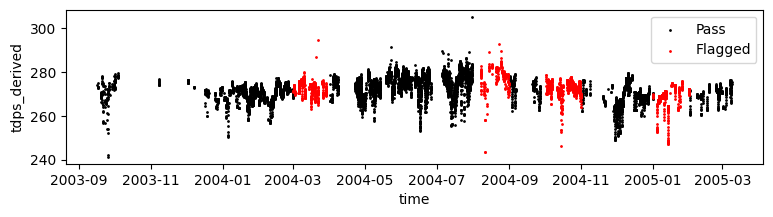

In [13]:
nice_plot_scatter(df, var='tdps_derived')

In [8]:
def plot_gap_scatter(df, var):
    
    yr_list = df['time'].dt.year.unique().tolist()
    num_yrs = len(yr_list)
    if num_yrs > 5:
        num_yrs = 3 # select specific years?
        
    # ideally would plot using the eraqc column as color -- need to find a way to add a color for nan values
    df_good = df.loc[df[var+'_eraqc'] != 18]
    df_bad = df.loc[df[var+'_eraqc'] == 18]
        
    month_fmt = DateFormatter('%b')
    def m_fmt(x, pos=None):
        return month_fmt(x)[0]  
    
    for yr in yr_list:    
        ax = df_good.loc[df['time'].dt.year == yr].plot.scatter(x='time', y=var, figsize=(6,2), s=1, color='k', label='Pass') 
        df_bad.loc[df_bad['time'].dt.year == yr].plot.scatter(x='time', y=var, figsize=(6,2), s=1, color='r', label='Flagged', ax=ax) 

        # what to do if one year of data has all nan values -- ex: sensor was added later on?
        ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
        ax.set_xlim(pd.Timestamp(str(yr)+'-01-01'), pd.Timestamp(str(yr)+'-12-31'))
        ax.set_ylim(int(df[var].min()), int(df[var].max())+1)
        ax.set_xlabel(yr) # for now
        
        # flagged/suspicious data in different color - need to overlap, not new axis
#         bad_vals = df.loc[df[var+'_eraqc'] == 18]
#         ax = bad_vals.loc[bad_vals['time'].dt.year == yr].plot.scatter(x='time', y=var, s=1, color='r', label='Flagged')


    # modify so that legend only appears once
    # legend item text size small, 2 cols


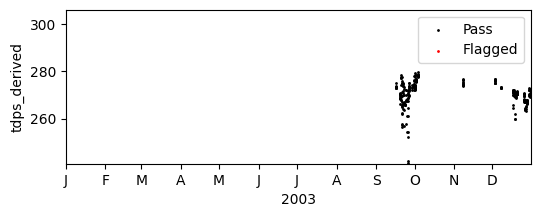

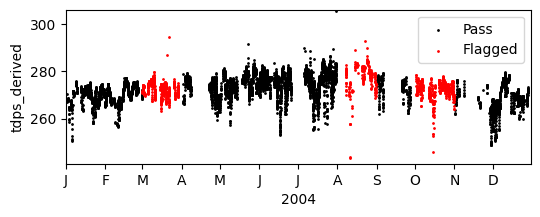

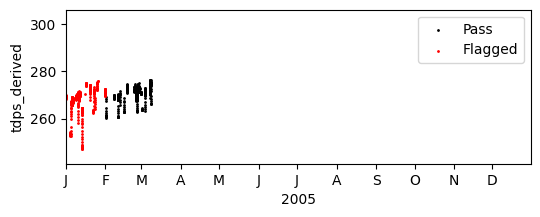

In [9]:
plot_gap_scatter(df, var='tdps_derived')

----
testing for part 2 below

In [ ]:
## part2 

# compare all observations in a single month, all years
# histogram created from all obs and gaussian distribution is fitted
# threshold values are determined using positions where fitted frequency falls below y=0.1
# and rounding outwards to the next integer plus one
# going outwards from center, distribution is scanned for gaps which occur outside threshold value
# obs beyond gap are flagged


## gaussian distribution may not be a perfect fit for bulk of obs, with thresholds too high
## allow for non-zero skew and kurtosis by using gauss-hermite series
## updated thresholds occur closer to bulk of distribution curve

#--------------------------------------------------------------------------------------
# intention is to have a function like: 

# def qaqc_dist_gaps_check(df, plot=False):
#     if plot=True:
#         plot_gap_check(df, var) # etc. 

In [ ]:
# identify the actual data vars
vars_to_remove = ['duration', 'method', 'lat', 'lon', 'elevation', 'qc', 'station', 'time', 'month', 'year']
[d for d in df.columns if not any(True for item in vars_to_remove if item in d)]

In [ ]:
def plot_gap_check(df, var):
    # plot histogram with count values against the standardized IQR
    num_bins = int(df[var].max()) + 1 - int(df[var].min())
    N = 10000 # what is this number - it matters!
    
    # standardize against IQR range
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    df_month_iqr = (df[var].values - df[var].median()) / iqr
    
    x = df_month_iqr
    plt.hist(x, bins=num_bins, alpha=0.3);
    xmin, xmax = plt.xlim()
    
    kur = stats.kurtosis(x, fisher=True)
    sk = stats.skew(x)

    # plot pdf
    if var == 'tas' or var == 'tdps' or var =='tdps_derived':
#         plt.xlim([-5,5])
        y = np.linspace(-5, 5, num_bins)
    else:
        y = np.linspace(xmin, xmax, num_bins)
    bin_width = (x.max() - x.min()) / num_bins
    plt.plot(y, stats.norm.pdf(y) * N * bin_width, color='k', lw=1)

    # add vertical lines to indicate thresholds -- clearly not correct
    pdf_idx = list(filter(lambda i: i > 0.1, stats.norm.pdf(y)))
    plt.axvline(x=y[stats.norm.pdf(y).tolist().index(pdf_idx[0])], color='r') # left tail
    plt.axvline(y[stats.norm.pdf(y).tolist().index(pdf_idx[-1])], color='r') # right tail
    
    plt.gca().set_yscale('log')

    # flag (visually) obs that are beyond threshold
    # bar_value_to_label = -2.25
    # patch_index = np.digitize([bar_value_to_label], x)[0]
    # hh.patches[patch_index].set_color('r')
    # hh.patches[patch_index].set_alpha(1)

    # title and useful annotations
    plt.title('QA/QC Distributional gap for {0}: {1}'.format(df_month['station'].unique()[0], var));
    plt.annotate('Month: {}'.format(m), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10);
    plt.annotate('Mean: {}'.format(round(np.nanmean(df_month_iqr),3)), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8);
    plt.annotate('Std.Dev: {}'.format(round(np.nanstd(df_month_iqr),3)), xy=(0.05, 0.85), xycoords='axes fraction', fontsize=8);
    plt.annotate('Skew: {}'.format(round(sk,3)), xy=(0.05,0.8), xycoords='axes fraction', fontsize=8)
    plt.annotate('Kurtosis: {}'.format(round(kur,3)), xy=(0.05, 0.75), xycoords='axes fraction', fontsize=8)
    plt.ylabel('Frequency (obs)')
    plt.xlabel('{} offset (IQR)'.format(var));
    
    # put AWS save figure stuffs here
    
    return

In [ ]:
m = 2
df_month = df.loc[df['month'] == m]

plot_gap_check(df_month, var='tas')

In [ ]:
# # identifying where pdf curve is below 0.1 threshold

# pdf_idx = list(filter(lambda i: i > 0.1, stats.norm.pdf(y).tolist()))
# pdf_idx